#  Codes du Projet du CoursIFT 7022

### Membre de l'équipe :

##### -Sekou Kaba
##### -Salah Eddine Khalil


In [1]:
!pip install librosa

# Importations des modules (A installer au cas de besoin):

In [65]:


import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

Il faudrait télécharger l'ensemble des données d'entrainement et de test sur son environnement 
A Partir du lien suivant : https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data.
On recueille les differentes étiquettes representant les mots

In [66]:
label=os.listdir('train/audio/')

On essaie de voir à quoi ressemble un son qui à été echantilloné : Cas du mot marvin avec un son quelconque


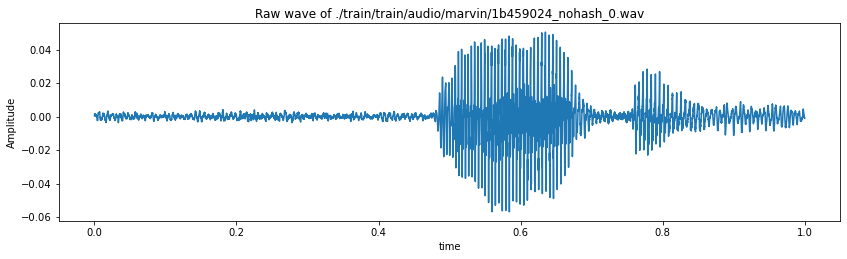

In [67]:
train_audio_path = './train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'marvin/1b459024_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + './train/train/audio/marvin/1b459024_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

On peut ecouter le son pour savoir qu'il s'agit clairement du mot :

In [69]:
ipd.Audio(samples, rate=sample_rate)

Et aussi voir la fréquence dans laquelle le mot à été echantillionné

In [70]:
print(sample_rate)

16000


Comme mentionné dans notre rapport associé, il est utlile de réechantionner le son.
Cette section s'en charge de ceci, en le ramenant à 8000Hz:
L'on constatera que le mot n'a pas été changé, mais juste le son qui reduit sa qualitée

In [71]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

Effectuons par la suite un comptage des mots pour chaque label:

In [72]:
#La liste des labels etant la suivante:
labels=os.listdir(train_audio_path)

Comptage et traçage d'un diagramme en baton

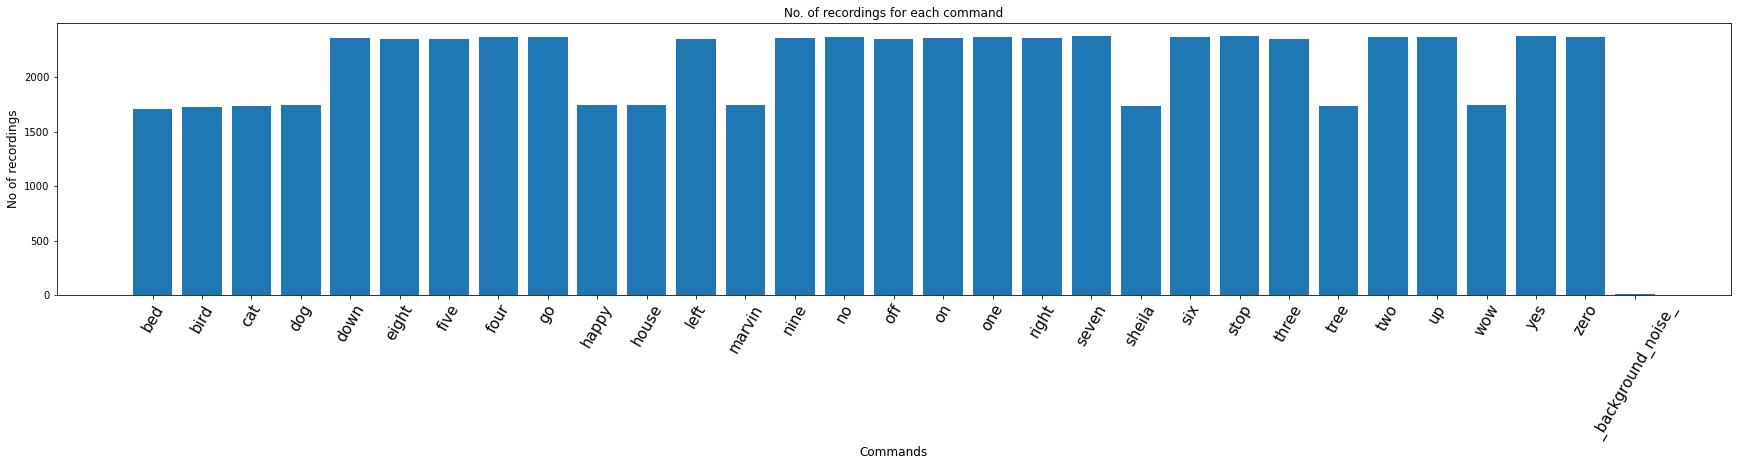

In [73]:
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    

plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

D'après le diagramme precedent, nous voudrions essayer de nous limiter qu'aux mots epéllés un grand nombre de fois. 
Nous nous limiterons ainsi à ces mots suivants : 
afin de facilité la suite de l'apprentissage et de reduire la complexité d'entrainement


In [74]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

Toujours dans le but d'explorer les données, on essaies de visualiser la durée de chaque son :

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

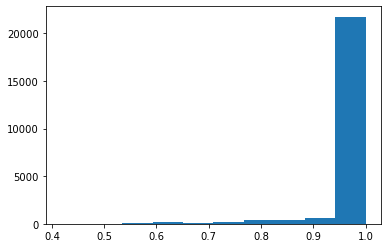

In [75]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

D'après l'étape precedente, on remarque qu'il existe un nombre de son dont la durée est inferieure à 1 seconde. 
Dans le but, toujours, de maximiser nos chances d'apprentissage, nous allions essayer de ne pas en tenir compte des sons dont la durée est inferieure à 1. 
De même, on essayera de reechantillonner tous les sons avant de passer à l'étape d'apprentissage.


In [76]:
train_audio_path = './train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


Pour ce qui suit, il est utile d'effectuer un encodage des labels en nombre entier.
Pour se faire, on utilisera l'encodeur de la librairie sklearn, comme suit :

In [77]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

Par la suite, convertissons les étiquettes codées, en un vecteur unique, utilisant le module keras.utils puisqu'il s'agit d'un problème de multi-classification :

In [78]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Changeons la dimension  du vecteur 2D en 3D puisque l'entrée du conv1d doit être un tableau 3D :

In [79]:
all_wave = np.array(all_wave).reshape(-1,8000)

Comme tout autre algorithme d'apprentissage, il est necessaire de diviser les données 
 en un ensemble de train, de test et de validation. 
Cette subdivison a été de base faite, mais la il s'agit tout simplement de diviser les données train 
 en 80% d'entrainement et 20% de validation

In [80]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

Passons à l'étape de la construction du modèle grace à Conv1D du module Keras, Il s'agit d'un modèle de reseau de neurone à convolution, qui effectue la convolution le long d'une seule dimension

In [81]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

Toujours etant donné qu'il s'agit d'un problème de classification, nous allons définir la fonction de perte comme étant une entropie croisée catégorique

In [82]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Afin d'eviter des pertes, nous allions rémedier aux arrêts précoces et creer un check point pour enregistrer le meilleur modèle, on pourra aussi l'utiliser par la suite, pour des fins de prédictions

In [83]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

C'est le moment d'entrainer notre modèle, sur un batch_size de 32

In [84]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - 187s 342ms/step - loss: 2.0919 - accuracy: 0.2105 - val_loss: 1.6939 - val_accuracy: 0.4014
Epoch 2/100
533/533 [==============================] - 177s 332ms/step - loss: 1.4531 - accuracy: 0.4664 - val_loss: 1.2552 - val_accuracy: 0.5491
Epoch 3/100
533/533 [==============================] - 180s 338ms/step - loss: 1.1210 - accuracy: 0.5977 - val_loss: 0.9259 - val_accuracy: 0.6648
Epoch 4/100
533/533 [==============================] - 176s 331ms/step - loss: 0.9588 - accuracy: 0.6684 - val_loss: 0.8807 - val_accuracy: 0.7023
Epoch 5/100
533/533 [==============================] - 168s 315ms/step - loss: 0.8386 - accuracy: 0.7085 - val_loss: 0.7689 - val_accuracy: 0.7401
Epoch 6/100
533/533 [==============================] - 168s 315ms/step - loss: 0.7829 - accuracy: 0.7301 - val_loss: 0.7086 - val_accuracy: 0.7682
Epoch 7/100
533/533 [==============================] - 167s 314ms/step - loss: 0.7227 - accuracy: 0.7461 - val_loss: 0

533/533 [==============================] - 162s 304ms/step - loss: 0.3701 - accuracy: 0.8724 - val_loss: 0.5130 - val_accuracy: 0.8386
Epoch 28/100
533/533 [==============================] - 162s 303ms/step - loss: 0.3613 - accuracy: 0.8751 - val_loss: 0.5020 - val_accuracy: 0.8405
Epoch 29/100
533/533 [==============================] - 162s 305ms/step - loss: 0.3719 - accuracy: 0.8721 - val_loss: 0.4945 - val_accuracy: 0.8410
Epoch 30/100
533/533 [==============================] - 17967s 34s/step - loss: 0.3328 - accuracy: 0.8852 - val_loss: 0.4970 - val_accuracy: 0.8424
Epoch 30: early stopping


Afin d'évaluer le modèle, passons au traçage du graphique de performance, qui compare la courbe de train et celle du test

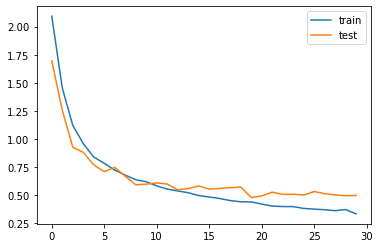

In [85]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Après l'obtention d'une bonne performance du modèle c'est maintenant le temps d'effectuer des prediction, pour cela, on charge le meilleur modèle enregistré au checkpoint

In [86]:
from keras.models import load_model
model=load_model('best_model.hdf5')

Puis on defini une fonction de prédiction, qui prend en entrée un audio, le réechantillone en 8000Hz, effectue par la suite la prédiction du label et retourne le label corespondant

In [87]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

Pour tester la fonction, on choisi au hazard un audio dans notre ensemble, comme suit

In [90]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: right


Puis on affiche la prediction

In [91]:
print("Text:",predict(samples))

1/1 [==============================] - 0s 31ms/step
Text: right
